In [2]:
import os
import time
import toml
import torch
import soundfile as sf
import numpy as np
from models.single_SSL_model import disesti_3


def return_src_posi(index):
    if index in [1, 2, 3, 4, 5]:
        src_posi = np.array([0, 3.0])
    elif index in [6, 7, 8, 9, 10]:
        src_posi = np.array([2.5, 3.0])
    elif index in [11, 12, 13, 14, 15]:
        src_posi = np.array([0.5, 3.0])
    elif index in [16, 17, 18, 19, 20]:
        src_posi = np.array([1, 3.0])
    elif index in [21, 22, 23, 24, 25]:
        src_posi = np.array([1.5, 3.0])
    elif index in [26, 27, 28, 29, 30]:
        src_posi = np.array([2.0, 3.0])
    elif index == 31:
        src_posi = np.array([2.0, 2.5])
    elif index == 32:
        src_posi = np.array([2.5, 2.5])
    elif index == 33:
        src_posi = np.array([1.5, 2.5])
    elif index == 34:
        src_posi = np.array([2.0, 2.0])
    elif index == 35:
        src_posi = np.array([2.5, 2.0])
    elif index == 36:
        src_posi = np.array([2.5, 1.5])
    elif index == 37:
        src_posi = np.array([2.5, 1.5])
    return src_posi

def read_txt_lines(txt_path):
    with open(txt_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    lines = [line.rstrip('\n') for line in lines]
    out = np.array([list(map(float, s.split())) for s in lines])
    return out

def recursive_average(nums):
    if len(nums) < 2:
        return nums
    new_nums = [(nums[i] + nums[i + 1]) / 2 for i in range(len(nums) - 1)]
    return recursive_average(new_nums)

os.environ['PATH'] = '/sbin:' + os.environ.get('PATH', '')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# configs
config = toml.load('./configs/real_audio/config.toml')

# models
model = disesti_3(device, **config['FFT']).to(device)
model.to(device)

checkpoint_path = './output/real_finetune/2025-02-23-15h18m/checkpoints/model_epoch_0300_loss_0.1096.tar'

checkpoint = torch.load(checkpoint_path, map_location=device)
model_weights = checkpoint['model']
model.load_state_dict(model_weights, strict=True)
model.eval()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('total_params',total_params)

# test dataset
audio_root_dirs   = './real_record/audio'
mic_pos_root_dirs = './real_record/mic_pos'
test_list         = [31,32] 
distant_est_result= {}
for i in test_list:
    print(f"real world set {i}:")
    used_file_index = [i] 
    interval = 0.1                # The recording interval is taken once every 100ms
    used_internal = 0.4           # An interval of 400ms used
    samplerate = 16000

    # total used audio & mic_pos
    total_used_audio = []
    total_posi = []

    for index in used_file_index:
        audio_path = os.path.join(audio_root_dirs, f"recorded_audio{index}.wav")
        posi_path = os.path.join(mic_pos_root_dirs, f"mic_pos_{index}.txt")
        src_posi = return_src_posi(index)

        audio, samplerate = sf.read(audio_path) # [wave length, channel]
        posis = read_txt_lines(posi_path)       # [len posi, 2] ([x, y])

        audio_slicses = []
        audio_step = int(used_internal * samplerate)
        audio_hop = int(0.1 * samplerate)                            
        audio_used_num = int((len(audio) - audio_step) // audio_hop)
        for i in range(0, audio_used_num):
            audio_slicses.append(audio[i * audio_hop : i * audio_hop + audio_step])

        posi_slicses = []
        posi_step = int(used_internal / interval)
        posi_hop = 1
        posi_used_num = int((len(posis) - posi_step) // posi_hop)

        for i in range(0, posi_used_num):
            used_x_posis = posis[i * posi_hop : i * posi_hop + posi_step, 0] #　list
            used_y_posis = posis[i * posi_hop : i * posi_hop + posi_step, 1] #　list
            
            tgt_x_dis = recursive_average(used_x_posis)
            tgt_y_dis = recursive_average(used_y_posis)
            posi_slicses.append(np.array([tgt_x_dis, tgt_y_dis]))

        total_used_audio.append(audio_slicses)
        total_posi.append(posi_slicses)

    total_esti_dis = []
    total_real_dis = []
    total_error = []
    start_time = time.time()
    for index in range(len(audio_slicses)):
        audio_input = torch.tensor(audio_slicses[index], dtype=torch.float32).unsqueeze(0).to(device) # [1, wave]
        esti_dis, all_value = model(audio_input, info = 1)

        # esti & real
        esti_dis = esti_dis.squeeze(0).cpu().detach().numpy() # 
        total_esti_dis.append(esti_dis)
        real_posi = posi_slicses[index]
        real_dis = np.sqrt((src_posi[0] - real_posi[0])**2 + (src_posi[1] - real_posi[1])**2)
        total_real_dis.append(real_dis)

        error = np.abs(esti_dis - real_dis)
        total_error.append(error)

        if index % 300 == 0 and index > 0 :
            end_time = time.time()
            print(f'index: {index}, esti_dis: {esti_dis}m, real_dis: {real_dis}m, error: {error}m, ave_time: {(end_time-start_time)/300}s')
            start_time = time.time()

    mean_error = sum(total_error) / len(total_error)
    print('mean_error', mean_error)
    data = {'posi_slicses': posi_slicses,
        'total_esti_dis': total_esti_dis,
        'total_real_dis': total_real_dis,
        'total_error': total_error,
        'src_posi': src_posi}
    distant_est_result[str(used_file_index[0])] = data

[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
total_params 42911
real world set 31:
index: 300, esti_dis: [2.635466]m, real_dis: [2.32961794]m, error: [0.30584816]m, ave_time: 0.07570058902104695s
index: 600, esti_dis: [1.7435453]m, real_dis: [1.49192254]m, error: [0.25162276]m, ave_time: 0.053442401885986326s
index: 900, esti_dis: [2.2353373]m, real_dis: [2.33087355]m, error: [0.09553629]m, ave_time: 0.058192614714304605s
index: 1200, esti_dis: [2.8089254]m, real_dis: [3.33555639]m, error: [0.526631]m, ave_time: 0.05400720040003459s
index: 1500, esti_dis: [3.0545073]m, real_dis: [3.48046622]m, error: [0.42595896]m, ave_time: 0.05397543748219808s
mean_error [0.22981776]
real world set 32:
index: 300, esti_dis: [3.8149257]m, real_dis: [2.54114274]m, error: [1.27378293]m, ave_time: 0.0580677851041158s
index: 600, esti_dis: [2.0881553]m, real_dis: [1.93968813]m, error: [0.14846714]m, ave_time: 0.054506324132283526s
index: 900, esti_dis: [3.118507]m, real_dis: [2.9247292

In [4]:
# Extended Kalman Filter

import numpy as np
import matplotlib.pyplot as plt
from  scipy.linalg import norm

def h_jacobian(x_i,SRC):
    delta_M_i = SRC - x_i
    T_i = np.zeros((1, 2))
    T_i[0,0] =  delta_M_i[0,0] / norm(delta_M_i)
    T_i[0,1] =  delta_M_i[1,0] / norm(delta_M_i)
    return T_i

# EKF for estimation sensors parameters
class e_kalman_filter(object):
    def __init__(self, Q, x0, P0,mic_pos):
        self.Q = Q
        self.z = 0
        self.x_est = x0
        self.P_est = P0
        self.path = mic_pos

    def update(self,k,mea):
        self.x_pred = self.x_est
        self.P_pred = self.P_est
        self.z = mea
        self.SRC = self.x_pred.reshape(-1, 1)
        self.x_i = self.path[k].reshape(-1, 1)
        d_est = norm(self.x_pred - self.x_i)
        mea_model_diff = np.array(self.z - d_est).reshape(-1,1)
        self.H = h_jacobian(self.x_i,self.SRC)
        
        # Kalman gain
        self.K = self.P_pred @ self.H.T @ np.linalg.inv(self.H @ self.P_pred @ self.H.T + self.Q)
        self.x_est = self.x_pred + self.K @ mea_model_diff
        self.P_est = (np.eye(len(self.x_est)) - self.K @ self.H) @ self.P_pred

class kalman_filter(object):
    def __init__(self,Q=1e-1, R=1e-1):
        self.Q = Q
        self.R = R
        self.K = 0.0  # kalman gain
        self.P = 0.0  # covariance
        self.x = 0.0  # states

    def update(self,data_last,data):
        # predict
        self.x = data_last
        self.P = self.P+self.Q

        # update
        self.K = self.P/(self.P+self.R)
        self.x = self.x + self.K * (data-self.x)
        self.P = (1-self.K)*self.P
        return self.x

def detect_and_replace_outliers(data, value, threshold=0.3):
    mean = np.mean(data)
    clean_data = np.copy(data)
    if abs(value - mean) > threshold:                     # outliers
        clean_data = np.append(clean_data, mean)
    else:
        clean_data = np.append(clean_data, value)
    return clean_data

------------dataset 31-------------------
1670 1670 1670 1670 2


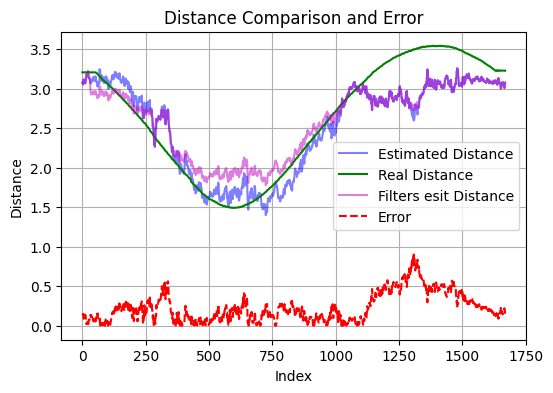

Estimated sound source postion:[2.01342855 2.21093239]
SSL ERROR:0.2893793557796933


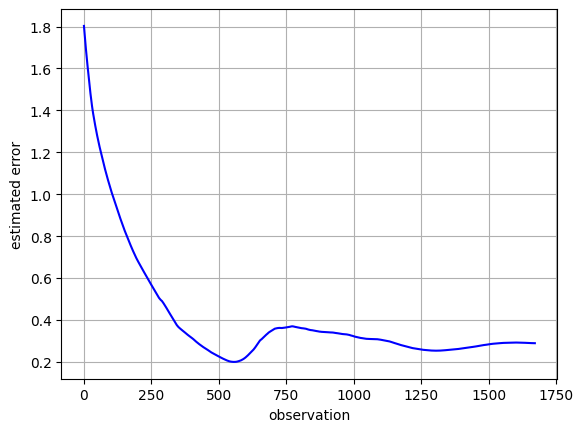

[[2.01342855]
 [2.21093239]]


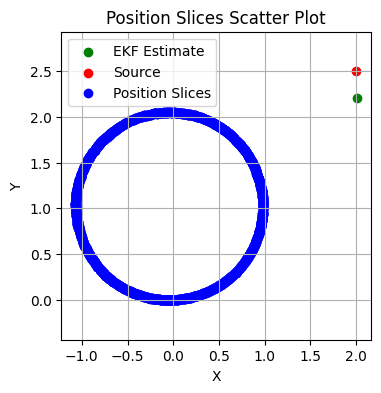

------------dataset 32-------------------
1653 1653 1653 1653 2


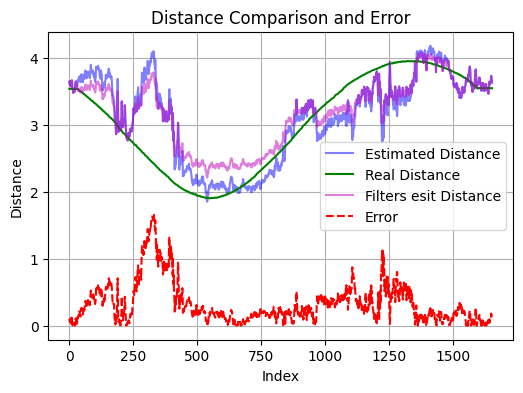

Estimated sound source postion:[2.38011765 2.70646144]
SSL ERROR:0.2387427592524151


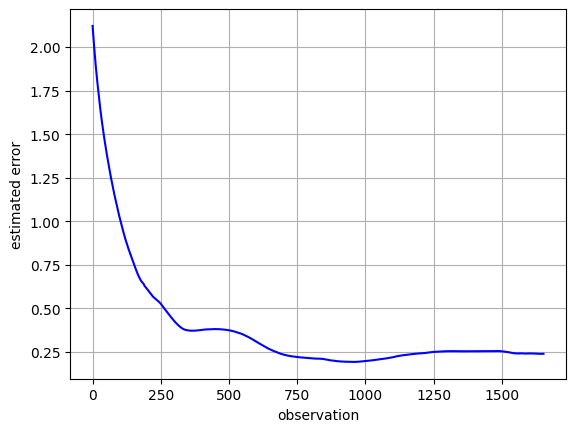

[[2.38011765]
 [2.70646144]]


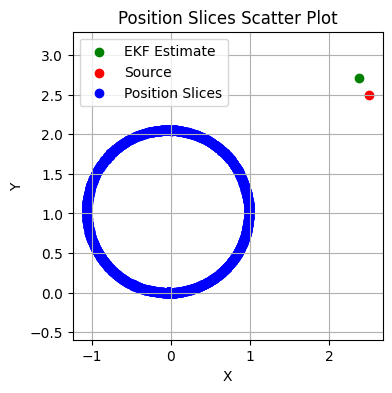

In [5]:
for j in distant_est_result.keys():
    print(f"------------dataset {j}-------------------")
    data_error  = np.zeros((1,0))
    loaded_data = distant_est_result[j]

    total_esti_dis = loaded_data['total_esti_dis']
    posi_slicses   = loaded_data['posi_slicses'][:len(total_esti_dis)]
    total_real_dis = loaded_data['total_real_dis']
    total_error    = loaded_data['total_error']
    src_posi       = loaded_data['src_posi']
    print(len(posi_slicses),len(total_esti_dis),len(total_real_dis),len(total_error),len(src_posi))

    total_esti_dis = np.array(loaded_data['total_esti_dis'])
    total_real_dis = np.array(loaded_data['total_real_dis'])
    total_error = np.array(loaded_data['total_error'])

    Q = 1; R=8;
    smooth_filter = kalman_filter(Q, R)
    d_real_mea_smooth = total_esti_dis.copy()
    filter_width = 30
    for i in range(len(d_real_mea_smooth)):
        if  i > filter_width:
            smoothed_data_in_window = d_real_mea_smooth[i-filter_width:]
            smoothed_data_in_window = detect_and_replace_outliers(smoothed_data_in_window, total_esti_dis[i])
            d_real_mea_smooth[i] = smooth_filter.update(d_real_mea_smooth[i], smoothed_data_in_window[-1])

    plt.figure(figsize=(6, 4))
    # Draw the estimated distance and the actual distance
    plt.plot(total_esti_dis, label='Estimated Distance', color='blue', alpha = 0.5)
    plt.plot(total_real_dis, label='Real Distance', color='green')
    plt.plot(d_real_mea_smooth, label='Filters esit Distance', color='m', alpha = 0.5)
    plt.plot(total_error, label='Error', color='red', linestyle='--')

    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.title('Distance Comparison and Error')
    plt.legend()
    plt.grid(True)
    plt.show()

    d_real_mea = np.array(loaded_data['total_esti_dis'])
    smooth_filter = kalman_filter(Q, R)
    d_real_mea_smooth = d_real_mea.copy()
    filter_width = 30

    total_posi_slicses = np.array(loaded_data['posi_slicses'][:len(total_esti_dis)])
    src_posi = np.array(loaded_data['src_posi'])

    # initial sound source position guess
    x0 = np.array([1, 1]).reshape(-1,1)      
    P0 = np.eye(2)           
    Q_mic = 100
    mic_ekf = e_kalman_filter(Q_mic, x0, P0, total_posi_slicses)
    error_all = (x0.reshape(-1)-src_posi).reshape(-1,2)
    uncertainty = np.array(np.sqrt(2)).reshape(-1,1)
    for i in range(len(total_posi_slicses)):
        if  i > filter_width:
            smoothed_data_in_window = d_real_mea_smooth[i-filter_width:]
            smoothed_data_in_window = detect_and_replace_outliers(smoothed_data_in_window, d_real_mea[i])
            d_real_mea_smooth[i] = smooth_filter.update(d_real_mea_smooth[i], smoothed_data_in_window[-1])
        # update
        mic_ekf.update(i,d_real_mea_smooth[i])
        # record
        error = mic_ekf.x_est.reshape(-1) - src_posi
        error_all = np.vstack([error_all,error])
        uncertainty = np.vstack([uncertainty, np.sqrt(mic_ekf.P_est[0,0]**2+mic_ekf.P_est[1,1]**2)])

    print(f"Estimated sound source postion:{mic_ekf.x_est.reshape(-1)}" )
    print(f"SSL ERROR:{norm(error_all[-1])}")

    plt.plot(range(len(error_all)),norm(error_all,axis=1),'b-')
    plt.xlabel('observation')
    plt.ylabel('estimated error')
    plt.grid()
    plt.show()

    # plot trajectory and estimated position
    total_posi_slicses = np.array(loaded_data['posi_slicses'])
    plt.figure(figsize=(4, 4))
    print(mic_ekf.x_est)
    plt.scatter(mic_ekf.x_est[0], mic_ekf.x_est[1], c='green', marker='o', label='EKF Estimate')
    plt.scatter(src_posi[0], src_posi[1], c='red', marker='o', label='Source')
    plt.scatter(total_posi_slicses[:, 0], total_posi_slicses[:, 1], c='blue', marker='o', label='Position Slices')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Position Slices Scatter Plot')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()
